# **Gobest Cab – Sprint 2 (CA2): ML Model for Trip Safety Prediction**
**Role:** Person A (ML Engineer)  
**Goal:** Train a machine learning model to classify trips as **Safe (0)** or **Dangerous (1)** using sensor data.

**Deliverables for Sprint 2:**
1. ML-focused EDA
2. Advanced Feature Engineering (≥10 new features, no leakage)
3. Model training + evaluation (and later deployment integration)
4. Track experiments (e.g., MLflow)


---

<mark> Why do we need Feature Selection? </mark>

- `The "Curse of Dimensionality"`: While 42 features isn't "massive," many of these (like speed, acceleration, and gyro) are likely highly correlated. Including redundant features adds "noise" that can confuse a model.

- `Efficiency vs. Performance`: By narrowing down to the top 15–20 features, we create a leaner model that is faster to train and easier to deploy in real-time environments (like in-car telematics).

- `Preventing Overfitting`: With a dataset size of ~16k rows, reducing features helps the model focus on the signal (driving behavior) rather than the noise (random fluctuations in sensor data).

<mark> How do we then find the 'best' features? <mark>

We will be using a Consensus Approach. We don't just trust one algorithm; we look for features that multiple different mathematical logic-centers agree on.

It will involve using 4 different methods and based off the results, we will be able to determine 'Powerful Features' based off its frequency of being chosen by the different methods

<mark> How does the features get chosen? </mark>
| Approach        | How It Works                                   | Pros                                   | Cons                                           |
|-----------------|-----------------------------------------------|----------------------------------------|------------------------------------------------|
| Top N (what we use) | Select N features with highest scores        | Consistent feature count, easy to compare | May include weak features if N is too high     |
| Threshold       | Select features above a score cutoff           | Only keeps "strong" features             | Unpredictable feature count, hard to set threshold |


We will go with **TOP N** because:
- Allows for consistent feature counts across methods
- No need to guess threshold value
- Inudstry standard practice

---

**METHODOLOGICAL NOTES:**
1. METHODOLOGY STATEMENT (DEFENSIVE):
   - Feature engineering was performed before train/test split because it was 
     deterministic (computed per trip without using labels or dataset-level statistics)
   - After splitting, all fitted transformations (encoding, SMOTE, model training) 
     were applied only on training data
   - Feature selection is performed ONLY on X_train_original (no SMOTE)

2. VALIDATION APPROACH:
   - Uses internal train/val split from original training data for sanity checks
   - Test set is NEVER used for feature selection decisions
   - Multiple consensus thresholds create different feature sets for experimentation

3. CONSENSUS STRATEGY:
   - Frequency voting across multiple methods (SelectKBest, RF, RFE, XGBoost)
   - Creates 4 experiment-ready feature sets:
     1. Strict: High consensus features only
     2. Moderate: Balanced selection
     3. Relaxed: Broader feature set
     4. Baseline: All features (control group)

4. OUTPUTS:
   - 4 complete dataset versions (PKL + CSV for teammate convenience)
   - Validation report comparing feature sets
   - Handoff document with clear recommendations
   - All artifacts logged to MLflow for reproducibility

5. EXPERIMENTATION READY:
   - Each feature set includes original and SMOTE versions
   - Consistent column ordering across train/test/SMOTE
   - Schema validation ensures no data leakage

---

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import pickle
import time
import json
import warnings
from collections import Counter
import hashlib
warnings.filterwarnings('ignore')

# Feature selection methods
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn

# XGBoost for additional method
try:
    import xgboost as xgb
    import mlflow.xgboost
    HAS_XGB = True
    print("XGBoost available")
except ImportError:
    HAS_XGB = False
    print("XGBoost not installed - will skip XGBoost method")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directories
dirs_to_create = ["datasets", "analysis/txt", "analysis/json", 
                  "analysis/csv", "analysis/plots", "analysis/reports"]
for directory in dirs_to_create:
    os.makedirs(directory, exist_ok=True)

# Constants
RANDOM_STATE = 42
N_JOBS = -1  # Use all cores
VALIDATION_SIZE = 0.2  # For internal validation split

print("Environment setup complete")
print(f"Working directory: {os.getcwd()}")
print()

XGBoost available
Environment setup complete
Working directory: c:\PAI\sprint_2



---

#### **STEP 1: LOAD DATA & SETUP MLFLOW**

---

1.1  Loading data

In [45]:
print("="*70)
print("PART 1: LOAD DATA & VERIFY INTEGRITY")
print("="*70)

print("\nLoading ORIGINAL training data (before SMOTE)...")
train_df = pd.read_pickle("datasets/X_train_original.pkl")
print(f"   Training data loaded: {train_df.shape}")

# Separate features and target
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']

# Basic validation
print(f"\nDataset Statistics:")
print(f"   Features (X_train): {X_train.shape[1]} columns, {X_train.shape[0]:,} rows")
print(f"   Target (y_train):   {y_train.shape[0]:,} samples")
print(f"   Class distribution: Safe={(y_train==0).sum():,} | Dangerous={(y_train==1).sum():,}")
print(f"   Imbalance ratio: {(y_train==0).sum() / (y_train==1).sum():.2f}:1")

# List all features for reference
all_feature_names = X_train.columns.tolist()
print(f"\nTotal features available: {len(all_feature_names)}")

PART 1: LOAD DATA & VERIFY INTEGRITY

Loading ORIGINAL training data (before SMOTE)...
   Training data loaded: (15938, 43)

Dataset Statistics:
   Features (X_train): 42 columns, 15,938 rows
   Target (y_train):   15,938 samples
   Class distribution: Safe=11,947 | Dangerous=3,991
   Imbalance ratio: 2.99:1

Total features available: 42


1.2 Categorizing features

In [46]:
# Categorize features for reporting
print("\nFeature Categories:")
feature_categories = {
    'Speed': [f for f in all_feature_names if 'speed' in f.lower()],
    'Acceleration': [f for f in all_feature_names if 'acc' in f.lower() or 'long_' in f.lower()],
    'Gyroscope': [f for f in all_feature_names if 'gyro' in f.lower()],
    'Events': [f for f in all_feature_names if any(x in f for x in ['harsh', 'speeding', 'turn', 'consec'])],
    'Rates': [f for f in all_feature_names if '_rate' in f.lower()],
    'Driver': [f for f in all_feature_names if any(x in f for x in ['age', 'experience', 'rating', 'gender', 'driver'])],
    'Other': [f for f in all_feature_names if not any([
        'speed' in f.lower(), 'acc' in f.lower(), 'gyro' in f.lower(),
        any(x in f for x in ['harsh', 'speeding', 'turn', 'consec']),
        '_rate' in f.lower(),
        any(x in f for x in ['age', 'experience', 'rating', 'gender', 'driver'])
    ])]
}

for category, features in feature_categories.items():
    if features:  # Only show non-empty categories
        print(f"   {category:15s}: {len(features):3d} features")


Feature Categories:
   Speed          :  12 features
   Acceleration   :   8 features
   Gyroscope      :   4 features
   Events         :  12 features
   Rates          :   5 features
   Driver         :   6 features
   Other          :   6 features


1.3 MLFLOW SETUP

In [47]:
# # Configure MLflow
# mlflow.set_tracking_uri("http://192.168.118.38:5000")  # Parveen's server
# experiment_name = "2_feature_selection"
# mlflow.set_experiment(experiment_name)
# experiment = mlflow.get_experiment_by_name(experiment_name)

# print(f"\nMLflow Configuration:")
# print(f"   Experiment: '{experiment_name}' (ID: {experiment.experiment_id})")
# print(f"   Tracking URI: {mlflow.get_tracking_uri()}")

# Configure MLflow (LOCAL SERVER)
mlflow.set_tracking_uri("http://127.0.0.1:5000")
experiment_name = "2_feature_selection"

mlflow.set_experiment(experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)

print("\nMLflow Configuration:")
print(f"   Experiment: '{experiment_name}' (ID: {experiment.experiment_id})")
print(f"   Tracking URI: {mlflow.get_tracking_uri()}")




MLflow Configuration:
   Experiment: '2_feature_selection' (ID: 327774575773294299)
   Tracking URI: http://127.0.0.1:5000


In [48]:
# Log basic parameters
with mlflow.start_run(run_name="Feature_Selection_Master"):
    mlflow.log_param("task", "1.3_feature_selection")
    mlflow.log_param("author", "gohyujie")
    mlflow.log_param("date", datetime.now().strftime("%Y-%m-%d"))
    mlflow.log_param("random_state", RANDOM_STATE)
    mlflow.log_param("n_original_features", X_train.shape[1])
    mlflow.log_param("train_samples", X_train.shape[0])
    
    # Methodology statement
    methodology = """
    METHODOLOGY:
    1. Feature engineering: Performed BEFORE train/test split (deterministic calculations)
    2. Transformations: Encoding, scaling, SMOTE applied ONLY on training data
    3. Feature selection: Performed ONLY on X_train_original (no SMOTE)
    4. Validation: Internal train/val split from training data only
    5. Test set: Reserved for final evaluation only
    """
    mlflow.set_tag("methodology", methodology)
    print("MLflow setup complete with methodology documentation")

MLflow setup complete with methodology documentation
🏃 View run Feature_Selection_Master at: http://127.0.0.1:5000/#/experiments/327774575773294299/runs/6eefb2f642a047e5984553b15301ce3a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/327774575773294299


---

#### <mark> **TAKE NOTE!** </mark>

Every methods, we are running and selecting different TOP N features because we will be running experiments later on during model training that helps determine and answer our hypothesis `Less features = less noise = better training results`


<br>

<mark> **Also why the top N for SelectKBest is different from others?** </mark>

**SelectKBest uses (15, 20, 25)**
- It scores each feature independently and does not consider feature interaction

- Small k (e.g. 10–15):
    - Risk of dropping useful interaction-based features

- Medium K (15-25):
    - Sweet spot for signal + coverage

- Large K (>25-30)
    - Often noisy, diminishing returns


<br>

**RF / RFE / XGBoost use (20, 25, 30)**
- All of them naturally down-weight weak features, are more robust with slightly larger feature sets and benefits from redundancy during early stages

- 20: Conservative

- 25: Balanced

- 30: Inclusive upper bound


---

#### **Step 2: Models**

---

**METHODS 1: SelectKBest (The Statistical Filter)**

- `How it works`: It uses an ANOVA F-test (f_classif) to look at each feature individually. It calculates whether the mean value of a feature is significantly different between "Safe" and "Dangerous" drivers.

- `What it does`: It acts as a Filter. It doesn't care how features work together; it only cares about the direct linear relationship between one feature and the target.

- `Analogy`: Like a scout looking at players' individual 100m sprint times.

- `Pros`: Fast, scale-invariant, good for removing irrelevant features
   
- `Cons`: Ignores feature interactions, can miss non-linear relationships

In [49]:
# Store all results for comparison
all_results = {}

In [50]:
print("\n" + "-"*70)
print("METHOD 1: SelectKBest (Statistical Filter)")
print("-"*70)

for k in [15, 20, 25]:  # Multiple k values for experimentation
    print(f"\nRunning SelectKBest with k={k}...")
    start_time = time.time()
    
    with mlflow.start_run(run_name=f"SelectKBest_k{k}", nested=True):
        # Log parameters
        mlflow.log_param("method", "SelectKBest")
        mlflow.log_param("score_function", "f_classif")
        mlflow.log_param("k", k)
        mlflow.log_param("n_features_total", X_train.shape[1])
        mlflow.log_param("data_source", "X_train_original")
        
        # Run selection
        selector = SelectKBest(score_func=f_classif, k=k)
        selector.fit(X_train, y_train)
        
        # Get results
        selected_mask = selector.get_support()
        selected_features = X_train.columns[selected_mask].tolist()
        selected_scores = selector.scores_[selected_mask]
        
        # Create importance DataFrame
        feature_importance = pd.DataFrame({
            'feature': selected_features,
            'score': selected_scores,
            'rank': range(1, len(selected_features) + 1)
        }).sort_values('score', ascending=False)
        
        duration = time.time() - start_time
        
        print(f"Selected {len(selected_features)} features in {duration:.1f}s")
        print(f"Top 5 features by F-score:")
        for i, row in feature_importance.head(5).iterrows():
            print(f"      {row['rank']:2d}. {row['feature']:30s} (score: {row['score']:.3f})")
        
        # Log metrics
        mlflow.log_metric("n_features_selected", k)
        mlflow.log_metric("execution_time_seconds", duration)
        mlflow.log_metric("mean_f_score", float(feature_importance['score'].mean()))
        mlflow.log_metric("max_f_score", float(feature_importance['score'].max()))
        
        # Save feature list
        feature_list_path = f"analysis/txt/temp_selectkbest_k{k}.txt"
        with open(feature_list_path, 'w') as f:
            f.write('\n'.join(selected_features))
        mlflow.log_artifact(feature_list_path, "feature_lists")
        os.remove(feature_list_path)
        
        # Create visualization
        fig, ax = plt.subplots(figsize=(10, 8))
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance)))
        bars = ax.barh(range(len(feature_importance)), feature_importance['score'], 
                      color=colors, edgecolor='black', height=0.7)
        
        # Add value labels
        for i, (bar, score) in enumerate(zip(bars, feature_importance['score'])):
            width = bar.get_width()
            ax.text(width * 1.01, bar.get_y() + bar.get_height()/2, 
                   f'{score:.1f}', va='center', fontsize=9)
        
        ax.set_yticks(range(len(feature_importance)))
        ax.set_yticklabels(feature_importance['feature'])
        ax.set_xlabel('F-Score (Higher = More Discriminative)', fontsize=12)
        ax.set_title(f'SelectKBest - Top {k} Features by ANOVA F-Test', fontsize=14, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        
        plot_path = f"analysis/plots/temp_selectkbest_k{k}.png"
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        mlflow.log_artifact(plot_path, "plots")
        os.remove(plot_path)
        
        # Set tags
        mlflow.set_tag("task", "1.3_feature_selection")
        mlflow.set_tag("method_category", "statistical_filter")
        mlflow.set_tag("feature_selection_type", "univariate")
        
        # Store results
        all_results[f"SelectKBest_k{k}"] = {
            'method': 'SelectKBest',
            'k': k,
            'features': selected_features,
            'scores': dict(zip(selected_features, selected_scores)),
            'duration': duration
        }
        
        print(f"Logged to MLflow")


----------------------------------------------------------------------
METHOD 1: SelectKBest (Statistical Filter)
----------------------------------------------------------------------

Running SelectKBest with k=15...
Selected 15 features in 0.2s
Top 5 features by F-score:
       1. trip_duration                  (score: 1608.702)
       8. sharp_turn_count               (score: 508.204)
       4. gyro_z_abs_p95                 (score: 351.917)
       2. gyro_z_std                     (score: 321.285)
      15. sharp_turn_rate                (score: 258.775)
Logged to MLflow
🏃 View run SelectKBest_k15 at: http://127.0.0.1:5000/#/experiments/327774575773294299/runs/2d1bafbf97ce441fba3e95b4c508308e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/327774575773294299

Running SelectKBest with k=20...
Selected 20 features in 0.2s
Top 5 features by F-score:
       1. trip_duration                  (score: 1608.702)
      11. sharp_turn_count               (score: 508.204)
       6

---

**METHOD 2: Random Forest Importance (The Ensemble Learner)**

- `How it works`: A Random Forest builds hundreds of decision trees. For every tree, it measures how much each feature helps in "purifying" the nodes (decreasing Gini impurity).

- `What it does`: This is an Embedded Method. It captures non-linear relationships and interactions between features (e.g., maybe Speed isn't dangerous alone, but Speed + High Gyro is).

- `Analogy`: Like a coach watching how players perform during a practice match to see who contributes most to a win.

- `Pros`: Captures non-linear relationships, handles interactions
   
- `Cons`: Can be biased toward high-cardinality features

In [51]:
# METHOD 2: RandomForest Importance
print("\n" + "-"*70)
print("METHOD 2: Random Forest Feature Importance")
print("-"*70)

for top_n in [20, 25, 30]:  # Multiple top_n values
    print(f"\nRunning RandomForest with top_n={top_n}...")
    start_time = time.time()
    
    with mlflow.start_run(run_name=f"RandomForest_top{top_n}", nested=True):
        # Log parameters
        mlflow.log_param("method", "RandomForest_Importance")
        mlflow.log_param("n_estimators", 100)
        mlflow.log_param("max_depth", 15)
        mlflow.log_param("top_n", top_n)
        mlflow.log_param("class_weight", "balanced_subsample")
        mlflow.log_param("data_source", "X_train_original")
        
        # Train model
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            class_weight='balanced_subsample',
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS
        )
        rf.fit(X_train, y_train)
        
        # Get feature importance
        importances = rf.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Select top features
        top_df = feature_importance.head(top_n).copy()
        selected_features = top_df['feature'].tolist()
        selected_importances = top_df['importance'].tolist()
        
        duration = time.time() - start_time
        
        print(f"   Selected {len(selected_features)} features in {duration:.1f}s")
        print(f"   Top 5 features by Gini importance:")
        for i, (feat, imp) in enumerate(zip(selected_features[:5], selected_importances[:5]), 1):
            print(f"      {i:2d}. {feat:30s} (importance: {imp:.4f})")
        
        # Log metrics
        mlflow.log_metric("n_features_selected", top_n)
        mlflow.log_metric("execution_time_seconds", duration)
        mlflow.log_metric("mean_importance", float(np.mean(selected_importances)))
        mlflow.log_metric("max_importance", float(np.max(selected_importances)))
        
        # Save feature list
        feature_list_path = f"analysis/txt/temp_rf_top{top_n}.txt"
        with open(feature_list_path, 'w') as f:
            f.write('\n'.join(selected_features))
        mlflow.log_artifact(feature_list_path, "feature_lists")
        os.remove(feature_list_path)
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Bar plot for top features
        colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(top_df)))
        bars1 = ax1.barh(range(len(top_df)), top_df['importance'], 
                        color=colors, edgecolor='black', height=0.7)
        
        for i, (bar, imp) in enumerate(zip(bars1, top_df['importance'])):
            width = bar.get_width()
            ax1.text(width * 1.01, bar.get_y() + bar.get_height()/2, 
                    f'{imp:.4f}', va='center', fontsize=9)
        
        ax1.set_yticks(range(len(top_df)))
        ax1.set_yticklabels(top_df['feature'])
        ax1.set_xlabel('Gini Importance', fontsize=12)
        ax1.set_title(f'Random Forest - Top {top_n} Features', fontsize=14, fontweight='bold')
        ax1.invert_yaxis()
        ax1.grid(axis='x', alpha=0.3)
        
        # Cumulative importance plot
        cumulative_importance = np.cumsum(feature_importance['importance'])
        ax2.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 
                'b-', linewidth=2, marker='o', markersize=4)
        ax2.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% threshold')
        ax2.axhline(y=0.90, color='g', linestyle='--', alpha=0.7, label='90% threshold')
        ax2.set_xlabel('Number of Features', fontsize=12)
        ax2.set_ylabel('Cumulative Importance', fontsize=12)
        ax2.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.set_xlim(0, min(50, len(cumulative_importance)))
        
        plt.tight_layout()
        plot_path = f"analysis/plots/temp_rf_top{top_n}.png"
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        mlflow.log_artifact(plot_path, "plots")
        os.remove(plot_path)
        
        # Log model
        mlflow.sklearn.log_model(sk_model=rf, artifact_path="model")
        
        # Set tags
        mlflow.set_tag("task", "1.3_feature_selection")
        mlflow.set_tag("method_category", "embedded")
        mlflow.set_tag("feature_selection_type", "model_based")
        
        # Store results
        all_results[f"RandomForest_top{top_n}"] = {
            'method': 'RandomForest',
            'k': top_n,
            'features': selected_features,
            'scores': dict(zip(selected_features, selected_importances)),
            'duration': duration
        }
        
        print(f"   Logged to MLflow")


----------------------------------------------------------------------
METHOD 2: Random Forest Feature Importance
----------------------------------------------------------------------

Running RandomForest with top_n=20...
   Selected 20 features in 1.2s
   Top 5 features by Gini importance:
       1. trip_duration                  (importance: 0.1377)
       2. avg_speed                      (importance: 0.0451)
       3. gyro_z_abs_p95                 (importance: 0.0322)
       4. acc_roll10_std_max             (importance: 0.0321)
       5. long_acc_min                   (importance: 0.0318)


2026/02/04 07:00:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   Logged to MLflow
🏃 View run RandomForest_top20 at: http://127.0.0.1:5000/#/experiments/327774575773294299/runs/9db45881eecf41b3ba4ff5a1094c1f61
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/327774575773294299

Running RandomForest with top_n=25...
   Selected 25 features in 1.3s
   Top 5 features by Gini importance:
       1. trip_duration                  (importance: 0.1377)
       2. avg_speed                      (importance: 0.0451)
       3. gyro_z_abs_p95                 (importance: 0.0322)
       4. acc_roll10_std_max             (importance: 0.0321)
       5. long_acc_min                   (importance: 0.0318)


2026/02/04 07:00:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   Logged to MLflow
🏃 View run RandomForest_top25 at: http://127.0.0.1:5000/#/experiments/327774575773294299/runs/aa8e2753e4074e27a6943b426e003526
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/327774575773294299

Running RandomForest with top_n=30...
   Selected 30 features in 1.2s
   Top 5 features by Gini importance:
       1. trip_duration                  (importance: 0.1377)
       2. avg_speed                      (importance: 0.0451)
       3. gyro_z_abs_p95                 (importance: 0.0322)
       4. acc_roll10_std_max             (importance: 0.0321)
       5. long_acc_min                   (importance: 0.0318)


2026/02/04 07:00:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   Logged to MLflow
🏃 View run RandomForest_top30 at: http://127.0.0.1:5000/#/experiments/327774575773294299/runs/51bd4fcf7a634e4d9ae5674bc6100bee
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/327774575773294299


---

**METHOD 3: RFE - Recursive Feature Elimination (The Wrapper)**

- `How it works`: It starts with all features, trains a model, identifies the weakest feature, and throws it away. It repeats this "elimination diet" until only the strongest 20 remain.

- `What it does`: This is a Wrapper Method. It is the most thorough because it accounts for how features behave when others are removed.

- `Analogy`: Like a "Survival of the Fittest" tournament where the weakest link is cut every round.

- `Pros`: Considers feature interactions, model-aware selection
   
- `Cons`: Computationally expensive, risk of overfitting to estimator

In [52]:
print("\n" + "-"*70)
print("METHOD 3: RFE (Recursive Feature Elimination)")
print("-"*70)

for n_features in [20, 25, 30]:  # Multiple target feature counts
    print(f"\nRunning RFE with n_features={n_features}...")
    start_time = time.time()
    
    with mlflow.start_run(run_name=f"RFE_n{n_features}", nested=True):
        # Log parameters
        mlflow.log_param("method", "RFE")
        mlflow.log_param("estimator", "RandomForestClassifier")
        mlflow.log_param("n_features_to_select", n_features)
        mlflow.log_param("step", 2)
        mlflow.log_param("n_estimators", 50)
        mlflow.log_param("data_source", "X_train_original")
        
        # Setup RFE
        estimator = RandomForestClassifier(
            n_estimators=50,
            max_depth=10,
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS
        )
        
        rfe = RFE(estimator=estimator, n_features_to_select=n_features, step=2)
        rfe.fit(X_train, y_train)
        
        # Get results
        selected_mask = rfe.support_
        selected_features = X_train.columns[selected_mask].tolist()
        rankings = rfe.ranking_
        
        duration = time.time() - start_time
        
        print(f"   Selected {len(selected_features)} features in {duration:.1f}s")
        print(f"   Selected features:")
        for i, feat in enumerate(selected_features[:10], 1):
            rank = rankings[X_train.columns.tolist().index(feat)]
            print(f"      {i:2d}. {feat:30s} (ranking: {rank})")
        
        # Log metrics
        mlflow.log_metric("n_features_selected", n_features)
        mlflow.log_metric("execution_time_seconds", duration)
        mlflow.log_metric("n_features_removed", X_train.shape[1] - n_features)
        
        # Save feature list
        feature_list_path = f"analysis/txt/temp_rfe_n{n_features}.txt"
        with open(feature_list_path, 'w') as f:
            f.write('\n'.join(selected_features))
        mlflow.log_artifact(feature_list_path, "feature_lists")
        os.remove(feature_list_path)
        
        # Create ranking visualization
        ranking_df = pd.DataFrame({
            'feature': X_train.columns,
            'ranking': rankings
        }).sort_values('ranking')
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Selected features
        selected_df = ranking_df[ranking_df['ranking'] == 1].head(20)
        colors1 = ['#2E86AB' if f in selected_features[:10] else '#A23B72' for f in selected_df['feature']]
        bars1 = ax1.barh(range(len(selected_df)), [1]*len(selected_df), 
                        color=colors1, edgecolor='black', height=0.7)
        ax1.set_yticks(range(len(selected_df)))
        ax1.set_yticklabels(selected_df['feature'])
        ax1.set_xlabel('Selected (1=Selected)', fontsize=12)
        ax1.set_title(f'RFE Selected Features (n={n_features})', fontsize=14, fontweight='bold')
        ax1.invert_yaxis()
        ax1.set_xlim(0, 2)
        
        # Feature rankings
        top_ranked = ranking_df.head(30).copy()
        colors2 = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(top_ranked)))
        bars2 = ax2.barh(range(len(top_ranked)), top_ranked['ranking'], 
                        color=colors2, edgecolor='black', height=0.7)
        
        for i, (bar, rank) in enumerate(zip(bars2, top_ranked['ranking'])):
            width = bar.get_width()
            ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{int(rank)}', va='center', fontsize=9)
        
        ax2.set_yticks(range(len(top_ranked)))
        ax2.set_yticklabels(top_ranked['feature'])
        ax2.set_xlabel('Ranking (1=Best)', fontsize=12)
        ax2.set_title('Feature Rankings from RFE', fontsize=14, fontweight='bold')
        ax2.invert_yaxis()
        ax2.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plot_path = f"analysis/plots/temp_rfe_n{n_features}.png"
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        mlflow.log_artifact(plot_path, "plots")
        os.remove(plot_path)
        
        # Set tags
        mlflow.set_tag("task", "1.3_feature_selection")
        mlflow.set_tag("method_category", "wrapper")
        mlflow.set_tag("feature_selection_type", "recursive_elimination")
        
        # Store results
        all_results[f"RFE_n{n_features}"] = {
            'method': 'RFE',
            'k': n_features,
            'features': selected_features,
            'scores': {},
            'rankings': dict(zip(X_train.columns, rankings)),
            'duration': duration
        }
        
        print(f"   Logged to MLflow")


----------------------------------------------------------------------
METHOD 3: RFE (Recursive Feature Elimination)
----------------------------------------------------------------------

Running RFE with n_features=20...
   Selected 20 features in 6.1s
   Selected features:
       1. trip_duration                  (ranking: 1)
       2. avg_speed                      (ranking: 1)
       3. max_speed                      (ranking: 1)
       4. speed_std                      (ranking: 1)
       5. speed_p95                      (ranking: 1)
       6. speed_p99                      (ranking: 1)
       7. long_acc_mean                  (ranking: 1)
       8. long_acc_std                   (ranking: 1)
       9. long_acc_min                   (ranking: 1)
      10. long_acc_max                   (ranking: 1)
   Logged to MLflow
🏃 View run RFE_n20 at: http://127.0.0.1:5000/#/experiments/327774575773294299/runs/5f78ebb65e054fd1be3640ca8f8147e7
🧪 View experiment at: http://127.0.0.1:5000/#/

---

**METHOD 4: XGBoost Gain (The Gradient Booster)**

- `How it works`: Similar to Random Forest, but XGBoost builds trees sequentially to fix the errors of previous trees. We use the "Gain" metric, which measures the actual improvement in accuracy brought by a specific feature.

- `What it does`: It focuses on the "hard to predict" cases. If a feature helps solve a difficult classification that other features missed, its "Gain" will be high.

- `Analogy`: A specialist scout looking for "clutch" players who perform well under pressure when the game is tied.

In [53]:
# METHOD 4: XGBoost (guarded)
if HAS_XGB:
    print("\n" + "-"*70)
    print("METHOD 4: XGBoost Feature Importance")
    print("-"*70)
    
    for top_n in [20, 25, 30]:  # Multiple top_n values
        print(f"\nRunning XGBoost with top_n={top_n}...")
        start_time = time.time()
        
        with mlflow.start_run(run_name=f"XGBoost_top{top_n}", nested=True):
            # Log parameters
            mlflow.log_param("method", "XGBoost_Importance")
            mlflow.log_param("n_estimators", 100)
            mlflow.log_param("max_depth", 6)
            mlflow.log_param("learning_rate", 0.1)
            mlflow.log_param("top_n", top_n)
            mlflow.log_param("importance_type", "gain")
            mlflow.log_param("data_source", "X_train_original")
            
            # Train model
            xgb_model = xgb.XGBClassifier(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=RANDOM_STATE,
                n_jobs=N_JOBS,
                importance_type='gain',
                eval_metric='logloss',
                use_label_encoder=False
            )
            xgb_model.fit(X_train, y_train)
            
            # Get importance
            importances = xgb_model.feature_importances_
            feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            # Select top features
            top_df = feature_importance.head(top_n).copy()
            selected_features = top_df['feature'].tolist()
            selected_importances = top_df['importance'].tolist()
            
            duration = time.time() - start_time
            
            print(f"   Selected {len(selected_features)} features in {duration:.1f}s")
            print(f"   Top 5 features by gain importance:")
            for i, (feat, imp) in enumerate(zip(selected_features[:5], selected_importances[:5]), 1):
                print(f"      {i:2d}. {feat:30s} (importance: {imp:.4f})")
            
            # Log metrics
            mlflow.log_metric("n_features_selected", top_n)
            mlflow.log_metric("execution_time_seconds", duration)
            mlflow.log_metric("mean_importance", float(np.mean(selected_importances)))
            mlflow.log_metric("max_importance", float(np.max(selected_importances)))
            
            # Save feature list
            feature_list_path = f"analysis/txt/temp_xgb_top{top_n}.txt"
            with open(feature_list_path, 'w') as f:
                f.write('\n'.join(selected_features))
            mlflow.log_artifact(feature_list_path, "feature_lists")
            os.remove(feature_list_path)
            
            # Create visualization
            fig, ax = plt.subplots(figsize=(12, 10))
            
            # Create gradient colors
            colors = plt.cm.magma(np.linspace(0.2, 0.9, len(top_df)))
            bars = ax.barh(range(len(top_df)), top_df['importance'], 
                          color=colors, edgecolor='black', height=0.7)
            
            # Add value labels
            for i, (bar, imp) in enumerate(zip(bars, top_df['importance'])):
                width = bar.get_width()
                ax.text(width * 1.01, bar.get_y() + bar.get_height()/2, 
                       f'{imp:.4f}', va='center', fontsize=9, fontweight='bold')
            
            ax.set_yticks(range(len(top_df)))
            ax.set_yticklabels(top_df['feature'])
            ax.set_xlabel('Gain Importance (Higher = More Predictive)', fontsize=12)
            ax.set_title(f'XGBoost - Top {top_n} Features by Split Gain', fontsize=14, fontweight='bold')
            ax.invert_yaxis()
            ax.grid(axis='x', alpha=0.3)
            
            plt.tight_layout()
            plot_path = f"analysis/plots/temp_xgb_top{top_n}.png"
            plt.savefig(plot_path, dpi=150, bbox_inches='tight')
            plt.close()
            mlflow.log_artifact(plot_path, "plots")
            os.remove(plot_path)
            
            # Log model
            mlflow.xgboost.log_model(xgb_model, "model")
            
            # Set tags
            mlflow.set_tag("task", "1.3_feature_selection")
            mlflow.set_tag("method_category", "embedded")
            mlflow.set_tag("feature_selection_type", "gradient_boosting")
            
            # Store results
            all_results[f"XGBoost_top{top_n}"] = {
                'method': 'XGBoost',
                'k': top_n,
                'features': selected_features,
                'scores': dict(zip(selected_features, selected_importances)),
                'duration': duration
            }
            
            print(f"   Logged to MLflow")
else:
    print("Skipping XGBoost method (not available)")


----------------------------------------------------------------------
METHOD 4: XGBoost Feature Importance
----------------------------------------------------------------------

Running XGBoost with top_n=20...
   Selected 20 features in 0.8s
   Top 5 features by gain importance:
       1. trip_duration                  (importance: 0.0958)
       2. gyro_z_abs_p95                 (importance: 0.0519)
       3. avg_speed                      (importance: 0.0462)
       4. car_model_year                 (importance: 0.0460)
       5. driver_rating                  (importance: 0.0402)


2026/02/04 07:00:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   Logged to MLflow
🏃 View run XGBoost_top20 at: http://127.0.0.1:5000/#/experiments/327774575773294299/runs/4ec555d93cee4d68bf6ec49152793601
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/327774575773294299

Running XGBoost with top_n=25...
   Selected 25 features in 0.5s
   Top 5 features by gain importance:
       1. trip_duration                  (importance: 0.0958)
       2. gyro_z_abs_p95                 (importance: 0.0519)
       3. avg_speed                      (importance: 0.0462)
       4. car_model_year                 (importance: 0.0460)
       5. driver_rating                  (importance: 0.0402)


2026/02/04 07:01:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   Logged to MLflow
🏃 View run XGBoost_top25 at: http://127.0.0.1:5000/#/experiments/327774575773294299/runs/573b33d165424805b051929a79fe3180
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/327774575773294299

Running XGBoost with top_n=30...
   Selected 30 features in 1.5s
   Top 5 features by gain importance:
       1. trip_duration                  (importance: 0.0958)
       2. gyro_z_abs_p95                 (importance: 0.0519)
       3. avg_speed                      (importance: 0.0462)
       4. car_model_year                 (importance: 0.0460)
       5. driver_rating                  (importance: 0.0402)


2026/02/04 07:01:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   Logged to MLflow
🏃 View run XGBoost_top30 at: http://127.0.0.1:5000/#/experiments/327774575773294299/runs/941e5cd240e247e7a84651f4fb333e45
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/327774575773294299


---

In [54]:
print("\nAll feature selection methods complete!")
print(f"   Total runs: {len(all_results)}")
print(f"   Methods used: {', '.join(set(r['method'] for r in all_results.values()))}")


All feature selection methods complete!
   Total runs: 12
   Methods used: XGBoost, SelectKBest, RandomForest, RFE


---

#### **Step 3: Feature Frequency Analysis (Method-Level Consensus)**

---

The reason for the final Frequency Analysis (the part where we count how many methods picked a feature) is to establish Consensus.

- `High Consensus (Green)`: If a feature is picked by SelectKBest, RF, RFE, and XGBoost, it is an undeniable "Power Feature."

- `Low Consensus (Red)`: If a feature is only picked by one method, it might be an artifact of that specific algorithm's logic rather than a true pattern in the data.



`Why Frequency Voting?`
1. Robustness: Features selected by multiple methods are more reliable
2. Method Diversity: Each method has biases; consensus reduces bias
3. Stability: Features consistently important across methods generalize better

`Our Approach:`
- Count how many times each feature appears across all method runs
- Create 4 consensus levels for experimentation:

1. Strict Consensus (conservative):
   - Features: Selected by ALL methods
   - Use case: When you want highest confidence features only
   - Risk: May be too restrictive, missing important features

2. Moderate Consensus (balanced):
   - Features: Selected by ≥75% of methods
   - Use case: Default starting point for model training
   - Risk: Balanced between confidence and coverage

3. Relaxed Consensus (inclusive):
   - Features: Selected by ≥50% of methods
   - Use case: When you want broader feature representation
   - Risk: May include some noisy features

4. Baseline (control):
   - Features: All original features
   - case: Benchmark to measure selection effectiveness
   - Risk: Includes all noise, prone to overfitting

**3.1 Calculate Method-Level Frequency**

In [55]:
# First, let's group by method to get unique selections per method
method_selections = {}
for result_name, result in all_results.items():
    method = result['method']
    if method not in method_selections:
        method_selections[method] = set()
    # Add all features selected by this method (across all its runs)
    method_selections[method].update(result['features'])

print(f"   Unique methods found: {len(method_selections)}")
print(f"   Methods: {', '.join(method_selections.keys())}")

# Now count how many UNIQUE METHODS selected each feature
feature_counter = Counter()
for method, features in method_selections.items():
    feature_counter.update(features)

# This is the key difference: n_methods = 4 (not 12)
n_methods = len(method_selections)  # Should be 4
print(f"   Total unique methods: {n_methods}")

   Unique methods found: 4
   Methods: SelectKBest, RandomForest, RFE, XGBoost
   Total unique methods: 4


**`Why we are now counting based off unique methods, not unique runs?`**
- Because we want consensus across different selection approaches,
not just multiple parameter settings of the same method.


In [56]:
# Now count how many UNIQUE METHODS selected each feature
feature_counter = Counter()
for method, features in method_selections.items():
    feature_counter.update(features)

# This is the key difference: n_methods = 4 (not 12)
n_methods = len(method_selections)  # Should be 4
print(f"   Total unique methods: {n_methods}")

# Create frequency DataFrame
frequency_df = pd.DataFrame({
    'feature': list(feature_counter.keys()),
    'frequency': list(feature_counter.values()),  # Out of 4 methods
    'percentage': [freq/n_methods*100 for freq in feature_counter.values()],
    'selected_by': [', '.join([m for m in method_selections if feat in method_selections[m]]) 
                   for feat in feature_counter.keys()]
}).sort_values(['frequency', 'feature'], ascending=[False, True]).reset_index(drop=True)

print(f"\nFeature Frequency Summary (out of {n_methods} methods):")
print(f"   Total unique features selected: {len(frequency_df)}")
print(f"   Features selected by ALL methods: {(frequency_df['frequency'] == n_methods).sum()}")
print(f"   Features selected by ≥3 methods: {(frequency_df['frequency'] >= 3).sum()}")
print(f"   Features selected by ≥2 methods: {(frequency_df['frequency'] >= 2).sum()}")
print(f"   Features selected by only 1 method: {(frequency_df['frequency'] == 1).sum()}")

   Total unique methods: 4

Feature Frequency Summary (out of 4 methods):
   Total unique features selected: 40
   Features selected by ALL methods: 16
   Features selected by ≥3 methods: 25
   Features selected by ≥2 methods: 34
   Features selected by only 1 method: 6


In [57]:
# Display top features
print("\nTop 20 Most Frequently Selected Features (by methods):")
top_features = frequency_df.head(20)
for i, row in top_features.iterrows():
    methods_list = row['selected_by'].split(', ')
    print(f"   {i+1:2d}. {row['feature']:35s} ({row['frequency']}/{n_methods} methods: {', '.join(methods_list[:3])})")


Top 20 Most Frequently Selected Features (by methods):
    1. acc_roll10_std_max                  (4/4 methods: SelectKBest, RandomForest, RFE)
    2. avg_speed                           (4/4 methods: SelectKBest, RandomForest, RFE)
    3. gyro_z_abs_p95                      (4/4 methods: SelectKBest, RandomForest, RFE)
    4. gyro_z_max                          (4/4 methods: SelectKBest, RandomForest, RFE)
    5. gyro_z_roll10_absmax_max            (4/4 methods: SelectKBest, RandomForest, RFE)
    6. gyro_z_std                          (4/4 methods: SelectKBest, RandomForest, RFE)
    7. highspeed_brake_interaction         (4/4 methods: SelectKBest, RandomForest, RFE)
    8. long_acc_max                        (4/4 methods: SelectKBest, RandomForest, RFE)
    9. long_acc_min                        (4/4 methods: SelectKBest, RandomForest, RFE)
   10. max_speed                           (4/4 methods: SelectKBest, RandomForest, RFE)
   11. speed_roll30_std_max                (4/4 method

In [58]:
# Save frequency analysis
frequency_csv_path = "analysis/csv/feature_frequency_method_level.csv"
frequency_df.to_csv(frequency_csv_path, index=False)
print(f"\nSaved method-level frequency analysis: {frequency_csv_path}")


Saved method-level frequency analysis: analysis/csv/feature_frequency_method_level.csv


---

**3.2 Create Method-Level Consensus Visualization**


Creating method-level frequency visualization...


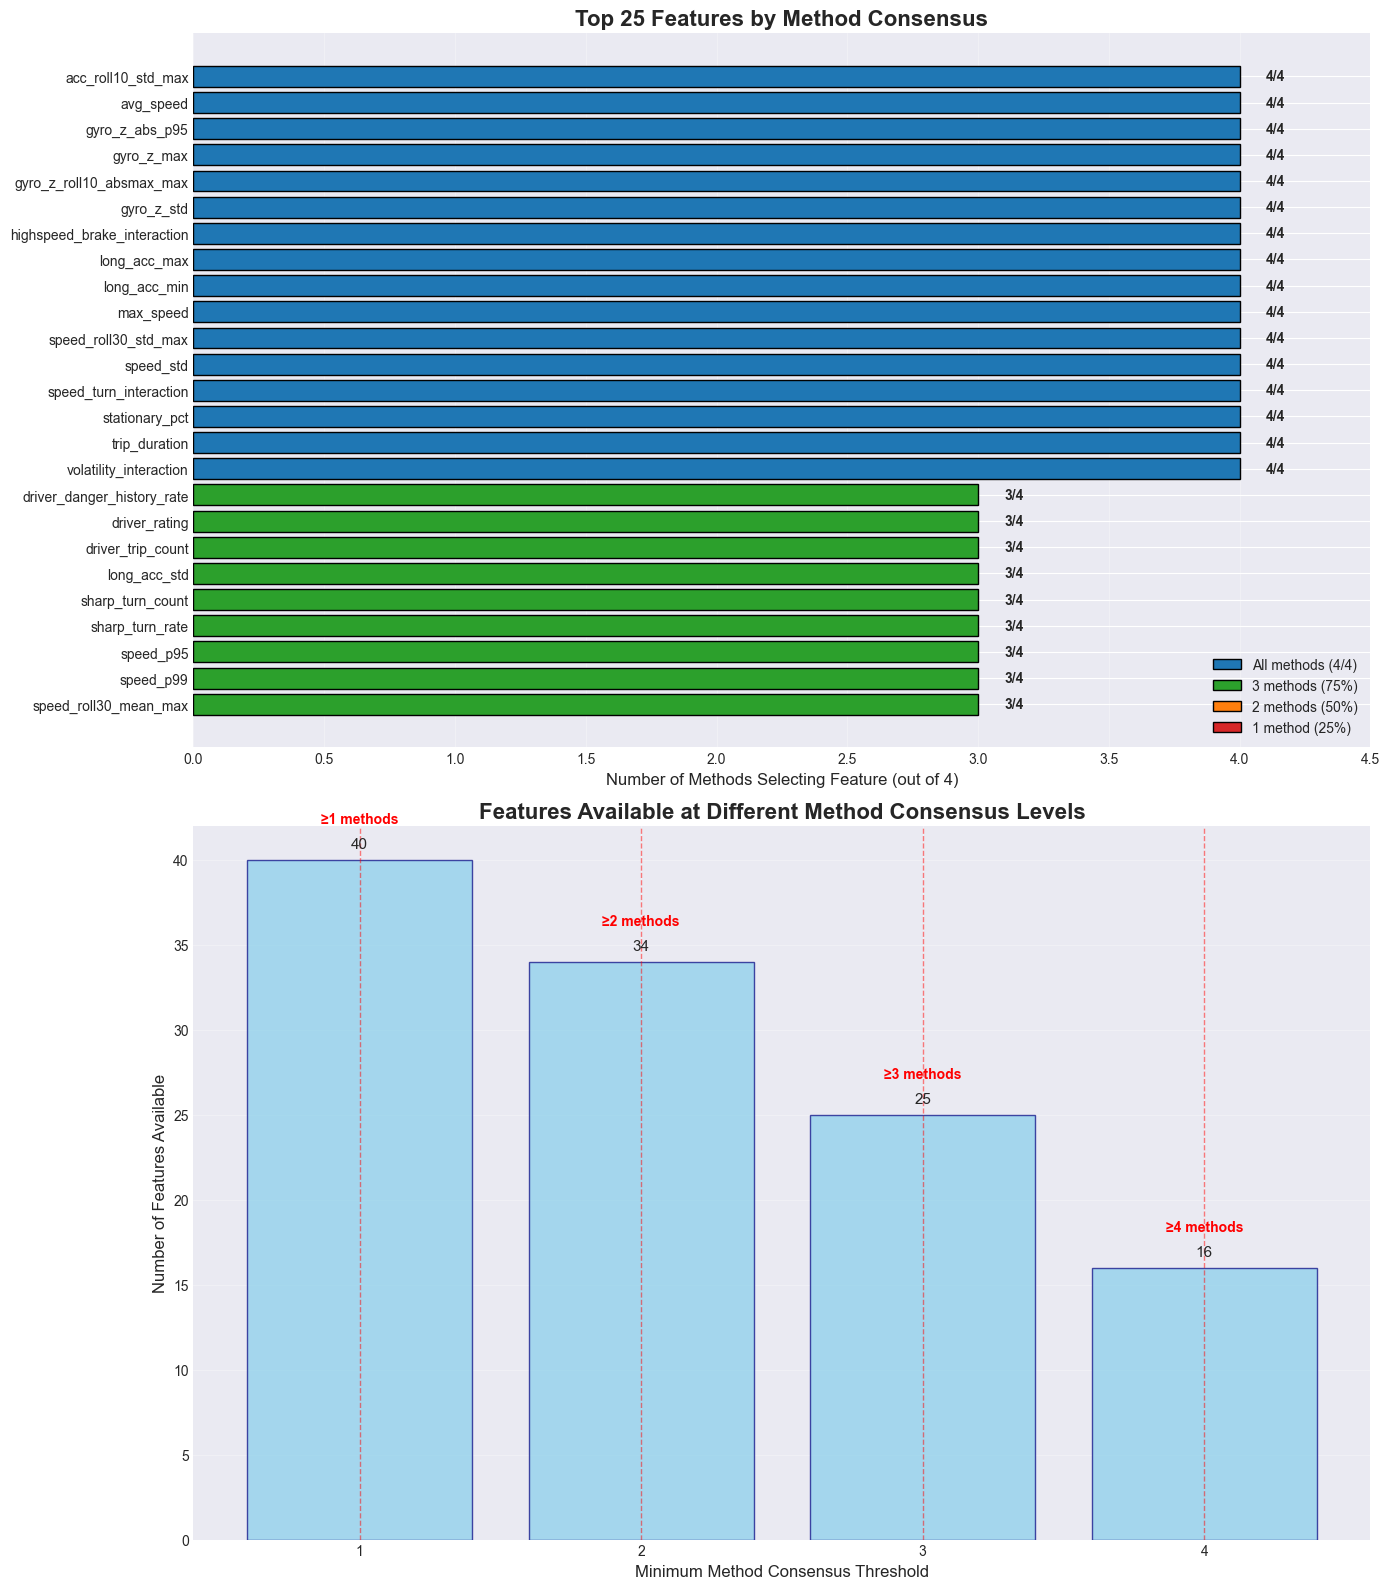

Saved method-level frequency plot: analysis/plots/feature_frequency_method_level.png


In [59]:
print("\nCreating method-level frequency visualization...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Top features bar plot
top_n_viz = min(25, len(frequency_df))
top_df_viz = frequency_df.head(top_n_viz).copy()

# Color coding based on method consensus
colors = []
for freq in top_df_viz['frequency']:
    if freq == n_methods:
        colors.append('#1f77b4')  # Blue for all methods
    elif freq == 3:
        colors.append('#2ca02c')  # Green for 3 methods
    elif freq == 2:
        colors.append('#ff7f0e')  # Orange for 2 methods
    else:
        colors.append('#d62728')  # Red for 1 method

bars1 = ax1.barh(range(len(top_df_viz)), top_df_viz['frequency'], 
                color=colors, edgecolor='black', height=0.8)

# Add value labels
for i, (bar, freq) in enumerate(zip(bars1, top_df_viz['frequency'])):
    width = bar.get_width()
    ax1.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{freq}/{n_methods}', va='center', fontsize=10, fontweight='bold')

ax1.set_yticks(range(len(top_df_viz)))
ax1.set_yticklabels(top_df_viz['feature'])
ax1.set_xlabel(f'Number of Methods Selecting Feature (out of {n_methods})', fontsize=12)
ax1.set_title(f'Top {top_n_viz} Features by Method Consensus', fontsize=16, fontweight='bold')
ax1.invert_yaxis()
ax1.set_xlim(0, n_methods + 0.5)
ax1.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black', label=f'All methods ({n_methods}/{n_methods})'),
    Patch(facecolor='#2ca02c', edgecolor='black', label=f'3 methods (75%)'),
    Patch(facecolor='#ff7f0e', edgecolor='black', label=f'2 methods (50%)'),
    Patch(facecolor='#d62728', edgecolor='black', label=f'1 method (25%)')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=10)

# Cumulative method consensus plot
freq_counts = frequency_df['frequency'].value_counts().sort_index()
cumulative_features = []
for freq in range(1, n_methods + 1):
    count = freq_counts.get(freq, 0)
    cumulative_features.append(count)

cumulative_sum = np.cumsum(cumulative_features[::-1])[::-1]

bars2 = ax2.bar(range(1, n_methods + 1), cumulative_sum, 
               color='skyblue', edgecolor='navy', alpha=0.7)
ax2.set_xlabel(f'Minimum Method Consensus Threshold', fontsize=12)
ax2.set_ylabel('Number of Features Available', fontsize=12)
ax2.set_title(f'Features Available at Different Method Consensus Levels', 
             fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(1, n_methods + 1))

# Add value labels on bars
for i, (x, y) in enumerate(zip(range(1, n_methods + 1), cumulative_sum)):
    if y > 0:
        ax2.text(x, y + 0.5, str(int(y)), ha='center', va='bottom', fontsize=11)

# Mark key thresholds
for threshold in [1, 2, 3, n_methods]:
    y_val = cumulative_sum[threshold-1] if threshold <= len(cumulative_sum) else 0
    ax2.axvline(x=threshold, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax2.text(threshold, y_val + 2, f'≥{threshold} methods', 
            ha='center', va='bottom', fontsize=10, color='red', fontweight='bold')

plt.tight_layout()
frequency_plot_path = "analysis/plots/feature_frequency_method_level.png"
plt.savefig(frequency_plot_path, dpi=150, bbox_inches='tight')
plt.show()
plt.close()

print(f"Saved method-level frequency plot: {frequency_plot_path}")

##### `Observations and Analysis`

**1. High Consensus Features (The "Core Drivers")**

An impressive 16 features achieved 100% consensus. This indicates a very stable signal across your different selection methods (Random Forest, XGBoost, etc.).

- `The Dominance of Gyroscope Data`: The "Gyro Z" suite remains a powerhouse. Features like gyro_z_max, gyro_z_std, and gyro_z_roll10_absmax_max all reached perfect consensus.

    - `Insight`: This confirms that lateral movement and rotational instability (swerving or fishtailing) are the most reliable indicators of dangerous driving, more so than simple linear movement.

- `The "Contextual" Trio`: Trip_duration, avg_speed, and max_speed all hit 4/4 consensus here.

    - `Analysis`:All models agree that the intensity of the trip (how fast you went and for how long) is a fundamental baseline for risk.

- `Feature Engineering Success`: volatility_interaction and highspeed_brake_interaction are both in the 100% as well.

    - `Interpretation`: These "interaction" features prove that risk isn't just about speed; it’s about speed combined with sudden changes. Breaking hard while at high speed is a much stronger signal than doing either individually.

---

**2. Moderate Consensus: The "Behavioral Nuance" (75% - 3/4 Methods)**

These 9 features are strong but might have non-linear or complex relationships that a simpler model (like a linear-based selector) might have missed.

- `Driver History & Ratings`: driver_danger_history_rate and driver_rating appear here.

    - `Insight`: While the vehicle's physics (telematics) are the primary predictors, the human element (past behavior) adds significant predictive power. It’s a "strong second" to the real-time sensor data.

- `Specific Event Counts`: sharp_turn_count and long_acc_std sit in this tier.

    - `Interpretation`: These are "event-based" features. They are highly predictive but might be slightly more "noisy" than the continuous sensor streams (like gyro_z_std), explaining why they didn't hit 100% consensus.

---

**3. Threshold Analysis (The Bottom Bar Chart)**

This chart tells us about the "dimensionality" of our problem.

- `The "Selection Wall"`: We have 40 features that are considered relevant by at least one method, but only 16 that are "unanimous."

- `The Strategy`: When building our final model, the 16 features in the 4/4 category should be our "Must-Haves." If our model can handle more complexity, expanding to the 25 features (the 3/4 threshold) would likely capture the best balance of signal vs. noise.

---

#### **Step 4: Create Method-Level Consensus Feature Sets**

---

1. `strict_4methods`: Features selected by ALL 4 methods
2. `moderate_3methods`: Features selected by ≥3 methods  
3. `relaxed_2methods`: Features selected by ≥2 methods
4. `baseline_all`: All original features (control)

In [60]:
# Define method-level consensus thresholds
consensus_configs = {
    "strict_4methods": {
        "threshold": n_methods,  # ALL 4 methods
        "description": "Highest confidence (selected by ALL methods)",
        "min_features": 5,
        "max_features": 20,
        "color": "#1f77b4",
        "experiment_tag": "conservative"
    },
    "moderate_3methods": {
        "threshold": 3,  # ≥3 out of 4 methods
        "description": "Balanced selection (selected by ≥3 methods)",
        "min_features": 10,
        "max_features": 30,
        "color": "#2ca02c", 
        "experiment_tag": "balanced"
    },
    "relaxed_2methods": {
        "threshold": 2,  # ≥2 out of 4 methods
        "description": "Inclusive selection (selected by ≥2 methods)",
        "min_features": 15,
        "max_features": 40,
        "color": "#ff7f0e",
        "experiment_tag": "inclusive"
    },
    "baseline_all": {
        "threshold": 0,  # All features
        "description": "Baseline - all original features",
        "min_features": X_train.shape[1],
        "max_features": X_train.shape[1],
        "color": "#d62728",
        "experiment_tag": "control"
    }
}

In [61]:
# Create feature sets
feature_sets = {}
print("\nCreating method-level consensus feature sets...")

for config_name, config in consensus_configs.items():
    threshold = config["threshold"]
    
    if config_name == "baseline_all":
        # Baseline includes all features
        selected_features = X_train.columns.tolist()
        n_selected = len(selected_features)
        print(f"   {config_name:20s}: {n_selected:3d} features ({config['description']})")
    else:
        # Filter by METHOD frequency threshold
        threshold_df = frequency_df[frequency_df["frequency"] >= threshold].copy()
        
        if len(threshold_df) == 0:
            print(f"   {config_name}: No features selected by ≥{threshold} methods")
            print(f"      Using top {config['min_features']} most frequent features instead")
            selected_features = frequency_df.head(config["min_features"])["feature"].tolist()
        else:
            selected_features = threshold_df["feature"].tolist()
        
        n_selected = len(selected_features)
        
        # Ensure minimum feature count
        if n_selected < config["min_features"]:
            print(f"   {config_name}: Only {n_selected} features (below min {config['min_features']})")
            print(f"      Expanding to top {config['min_features']} features meeting threshold")
            selected_features = threshold_df.head(config["min_features"])["feature"].tolist()
            n_selected = len(selected_features)
        
        # Cap at maximum features
        if n_selected > config["max_features"]:
            print(f"   {config_name}: {n_selected} features (above max {config['max_features']})")
            print(f"      Trimming to top {config['max_features']} features")
            selected_features = selected_features[:config["max_features"]]
            n_selected = len(selected_features)
        
        # Store with method consensus info
        method_info = {}
        for feat in selected_features:
            freq = int(frequency_df[frequency_df['feature'] == feat]['frequency'].iloc[0])
            methods = frequency_df[frequency_df['feature'] == feat]['selected_by'].iloc[0]
            method_info[feat] = {
                'method_count': freq,
                'methods': methods
            }
        
        feature_sets[config_name] = {
            "features": selected_features,
            "n_features": n_selected,
            "threshold": threshold,
            "description": config["description"],
            "color": config["color"],
            "experiment_tag": config["experiment_tag"],
            "method_info": method_info
        }
        
        print(f"   {config_name:20s}: {n_selected:3d} features (≥{threshold}/{n_methods} methods, {config['description']})")



Creating method-level consensus feature sets...
   strict_4methods     :  16 features (≥4/4 methods, Highest confidence (selected by ALL methods))
   moderate_3methods   :  25 features (≥3/4 methods, Balanced selection (selected by ≥3 methods))
   relaxed_2methods    :  34 features (≥2/4 methods, Inclusive selection (selected by ≥2 methods))
   baseline_all        :  42 features (Baseline - all original features)


In [62]:
# Feature stability check
levels = sorted([f"≥{v['threshold']}" for k, v in consensus_configs.items() if k != 'baseline_all'])
print(f"   Consensus levels: {', '.join(levels)}")

for config_name, data in feature_sets.items():
    if config_name != "baseline_all":
        n_feat = data["n_features"]
        threshold = data["threshold"]
    
        if threshold == n_methods:
            if n_feat < 5:
                print(f"   {config_name}: Only {n_feat} features selected by all methods (Low coverage)")
            else:
                print(f"   {config_name}: {n_feat} features - Strong unanimous core")
        
        elif threshold == 3:
            if 10 <= n_feat <= 25:
                print(f"   {config_name}: {n_feat} features - Optimal range for model experimentation")
            else:
                print(f"   {config_name}: {n_feat} features at threshold 3")
                
        elif threshold == 2:
            if n_feat > 35:
                print(f"   {config_name}: {n_feat} features - Caution: High dimensionality/Noise risk")
            else:
                print(f"   {config_name}: {n_feat} features at threshold 2")
        
        else:
            print(f"   {config_name}: {n_feat} features at ≥{threshold} method consensus")

   Consensus levels: ≥2, ≥3, ≥4
   strict_4methods: 16 features - Strong unanimous core
   moderate_3methods: 25 features - Optimal range for model experimentation
   relaxed_2methods: 34 features at threshold 2


In [63]:
# Save feature set definitions
feature_sets_path = "analysis/json/feature_sets_method_consensus.json"
with open(feature_sets_path, 'w') as f:
    json.dump({
        "feature_sets": {k: {**v, 'method_info': {}} for k, v in feature_sets.items()},  # Remove method_info for JSON
        "n_methods": n_methods,
        "method_names": list(method_selections.keys()),
        "total_features": X_train.shape[1],
        "creation_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "consensus_thresholds": {k: v["threshold"] for k, v in consensus_configs.items()}
    }, f, indent=2, default=str)

print(f"\nSaved method-level feature set definitions: {feature_sets_path}")


Saved method-level feature set definitions: analysis/json/feature_sets_method_consensus.json


---

#### **Step 5: Save All Datasets For Model Training**

---

1. We save ALL feature sets for model training experimentation
2. NO validation here - that happens in model training notebook
3. Each feature set has 3 versions:
   - Original training (no SMOTE)
   - SMOTE-balanced training  
   - Test set (untouched)

In [64]:
print("\nLoading SMOTE and test datasets...")
train_smote_df = pd.read_pickle("datasets/X_train_smote.pkl")
test_df = pd.read_pickle("datasets/X_test.pkl")

X_train_smote = train_smote_df.drop(columns=['label'])
y_train_smote = train_smote_df['label']

X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

print(f"   X_train_smote: {X_train_smote.shape}")
print(f"   X_test:        {X_test.shape}")

# Create and save datasets for each feature set
datasets_created = {}
print("\nCreating and saving all feature-filtered datasets...")

for config_name, data in feature_sets.items():
    features = data["features"]
    n_features = data["n_features"]
    
    print(f"\n   Processing: {config_name} ({n_features} features)")
    
    # 1. Validate feature presence
    missing_in_train = [f for f in features if f not in X_train.columns]
    missing_in_smote = [f for f in features if f not in X_train_smote.columns]
    missing_in_test = [f for f in features if f not in X_test.columns]
    
    if missing_in_train or missing_in_smote or missing_in_test:
        print(f"      WARNING: Features missing in some datasets!")
        if missing_in_train: print(f"         Missing in train: {missing_in_train}")
        if missing_in_smote: print(f"         Missing in smote: {missing_in_smote}")
        if missing_in_test: print(f"         Missing in test: {missing_in_test}")
        raise ValueError("Feature consistency check failed!")
    
    # 2. Create filtered datasets
    X_train_filtered = X_train[features].copy()
    X_train_smote_filtered = X_train_smote[features].copy()
    X_test_filtered = X_test[features].copy()
    
    # Verify consistent column order
    assert list(X_train_filtered.columns) == list(features), "Column order mismatch in train"
    assert list(X_train_smote_filtered.columns) == list(features), "Column order mismatch in smote"
    assert list(X_test_filtered.columns) == list(features), "Column order mismatch in test"
    
    # 3. Create DataFrames with labels
    train_final = X_train_filtered.copy()
    train_final['label'] = y_train.values
    
    train_smote_final = X_train_smote_filtered.copy()
    train_smote_final['label'] = y_train_smote.values
    
    test_final = X_test_filtered.copy()
    test_final['label'] = y_test.values
    
    # 4. Generate filenames
    suffix = f"_{config_name}_{n_features}feat"
    
    # PKL files (fast loading)
    train_pkl = f"datasets/X_train{suffix}.pkl"
    train_smote_pkl = f"datasets/X_train_smote{suffix}.pkl"
    test_pkl = f"datasets/X_test{suffix}.pkl"
    features_pkl = f"datasets/features{suffix}.pkl"
    
    # CSV files (human readable)
    train_csv = f"analysis/csv/X_train{suffix}.csv"
    train_smote_csv = f"analysis/csv/X_train_smote{suffix}.csv"
    test_csv = f"analysis/csv/X_test{suffix}.csv"
    features_txt = f"analysis/txt/features{suffix}.txt"
    
    # 5. Save PKL files
    train_final.to_pickle(train_pkl)
    train_smote_final.to_pickle(train_smote_pkl)
    test_final.to_pickle(test_pkl)
    with open(features_pkl, 'wb') as f:
        pickle.dump(features, f)
    
    # 6. Save CSV/TXT files
    train_final.to_csv(train_csv, index=False)
    train_smote_final.to_csv(train_smote_csv, index=False)
    test_final.to_csv(test_csv, index=False)
    with open(features_txt, 'w') as f:
        f.write('\n'.join(features))
    
    # 7. Record created datasets
    datasets_created[config_name] = {
        "n_features": n_features,
        "files": {
            "pkl": [train_pkl, train_smote_pkl, test_pkl, features_pkl],
            "csv": [train_csv, train_smote_csv, test_csv, features_txt]
        },
        "description": data["description"],
        "threshold": data["threshold"]
    }
    
    print(f"      Saved: {train_pkl}")
    print(f"      Saved: {train_smote_pkl}")
    print(f"      Saved: {test_pkl}")
    print(f"      Saved: {features_pkl}")

print(f"\nCreated {len(datasets_created)} complete dataset sets for model training experimentation")



Loading SMOTE and test datasets...
   X_train_smote: (23894, 42)
   X_test:        (3985, 42)

Creating and saving all feature-filtered datasets...

   Processing: strict_4methods (16 features)


      Saved: datasets/X_train_strict_4methods_16feat.pkl
      Saved: datasets/X_train_smote_strict_4methods_16feat.pkl
      Saved: datasets/X_test_strict_4methods_16feat.pkl
      Saved: datasets/features_strict_4methods_16feat.pkl

   Processing: moderate_3methods (25 features)
      Saved: datasets/X_train_moderate_3methods_25feat.pkl
      Saved: datasets/X_train_smote_moderate_3methods_25feat.pkl
      Saved: datasets/X_test_moderate_3methods_25feat.pkl
      Saved: datasets/features_moderate_3methods_25feat.pkl

   Processing: relaxed_2methods (34 features)
      Saved: datasets/X_train_relaxed_2methods_34feat.pkl
      Saved: datasets/X_train_smote_relaxed_2methods_34feat.pkl
      Saved: datasets/X_test_relaxed_2methods_34feat.pkl
      Saved: datasets/features_relaxed_2methods_34feat.pkl

Created 3 complete dataset sets for model training experimentation


In [65]:
# Save dataset manifest
manifest_path = "analysis/json/dataset_manifest_method_consensus.json"
manifest = {
    "datasets_created": datasets_created,
    "n_methods": n_methods,
    "method_names": list(method_selections.keys()),
    "total_features_original": X_train.shape[1],
    "creation_timestamp": datetime.now().isoformat(),
    "note": "All datasets saved for model training experimentation. No validation performed here."
}

with open(manifest_path, 'w') as f:
    json.dump(manifest, f, indent=2, default=str)

print(f"Saved dataset manifest: {manifest_path}")

Saved dataset manifest: analysis/json/dataset_manifest_method_consensus.json


---

#### **Step 6: Comprehensive MLflow Loggin (No Validation)**

---

`MLFLOW LOGGING STRATEGY:`

We log everything needed for reproducibility and analysis:
1. All method runs (already logged individually)
2. Method-level frequency analysis
3. Feature set definitions
4. Dataset manifests
5. NO validation metrics (saved for model training)

This creates a complete feature selection experiment
without pre-judging which feature set is best.

In [66]:
with mlflow.start_run(run_name="Feature_Selection_Method_Consensus_Summary"):
    # 1. Log parameters
    mlflow.log_param("task", "1.3_feature_selection")
    mlflow.log_param("author", "gohyujie")
    mlflow.log_param("date", datetime.now().strftime("%Y-%m-%d"))
    mlflow.log_param("random_state", RANDOM_STATE)
    mlflow.log_param("n_unique_methods", n_methods)
    mlflow.log_param("method_names", ", ".join(method_selections.keys()))
    mlflow.log_param("n_feature_sets_created", len(feature_sets))
    mlflow.log_param("feature_set_names", ", ".join(feature_sets.keys()))
    mlflow.log_param("consensus_strategy", "method_level_voting")
    mlflow.log_param("validation_performed", "no")
    
    # 2. Log metrics (descriptive, not performance)
    mlflow.log_metric("n_original_features", X_train.shape[1])
    mlflow.log_metric("n_unique_selected_features", len(frequency_df))
    mlflow.log_metric("features_in_all_methods", int(frequency_df['frequency'].max()))
    mlflow.log_metric("avg_features_per_method", float(np.mean([len(f) for f in method_selections.values()])))
    
    # 3. Log artifacts
    mlflow.log_artifact(frequency_csv_path, "analysis/method_frequency")
    mlflow.log_artifact(frequency_plot_path, "visualizations/method_frequency")
    mlflow.log_artifact(feature_sets_path, "definitions/feature_sets")
    mlflow.log_artifact(manifest_path, "definitions/dataset_manifest")
    
    # 4. Log feature lists for each set
    for config_name, data in feature_sets.items():
        feat_txt = f"analysis/txt/features_{config_name}_{data['n_features']}feat.txt"
        if os.path.exists(feat_txt):
            mlflow.log_artifact(feat_txt, f"feature_lists/{config_name}")
    
    # 5. Set comprehensive tags
    mlflow.set_tag("task", "1.3_feature_selection")
    mlflow.set_tag("run_type", "method_consensus_summary")
    mlflow.set_tag("author", "gohyujie")
    mlflow.set_tag("status", "complete")
    mlflow.set_tag("experimentation_ready", "true")
    mlflow.set_tag("validation_strategy", "deferred_to_model_training")
    mlflow.set_tag("consensus_level", "method_based")
    
    # 6. Create detailed description
    description = f"""
FEATURE SELECTION - METHOD-LEVEL CONSENSUS SUMMARY
==================================================

EXECUTIVE OVERVIEW:
- Original features: {X_train.shape[1]}
- Unique methods used: {n_methods} ({', '.join(method_selections.keys())})
- Feature sets created: {len(feature_sets)}
- Method-level consensus strategy applied

METHODOLOGY:
1. Feature engineering: BEFORE train/test split (deterministic)
2. Transformations: ONLY on training data
3. Feature selection: X_train_original only (no SMOTE)
4. Method consensus: Counted by UNIQUE METHODS (4), not runs (12)
5. Validation: DEFERRED to model training phase
6. Test set: Completely untouched

METHOD-LEVEL CONSENSUS RESULTS:
{chr(10).join([f"- Features selected by {i} methods: {(frequency_df['frequency'] == i).sum()}" for i in range(1, n_methods+1)])}

FEATURE SETS CREATED (for model training experimentation):
{chr(10).join([f"- {name}: {data['n_features']} features ({data['description']})" for name, data in feature_sets.items()])}

DATASETS SAVED:
Each feature set saved as:
• X_train_{{config}}_{{n}}feat.pkl (original training)
• X_train_smote_{{config}}_{{n}}feat.pkl (SMOTE-balanced)
• X_test_{{config}}_{{n}}feat.pkl (test set)
• features_{{config}}_{{n}}feat.pkl (feature list)

DECISION STRATEGY:
No feature set is selected as "best" here.
All {len(feature_sets)} sets are provided for experimentation in model training.
Final selection will be based on actual model performance.

NEXT STEPS (Model Training):
1. Experiment with ALL feature sets
2. Compare model performance across sets
3. Select best performing feature set based on validation
4. Final evaluation on test set

Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    """
    
    mlflow.set_tag("mlflow.note.content", description)
    
    print("✅ Method-level consensus summary logged to MLflow")


✅ Method-level consensus summary logged to MLflow
🏃 View run Feature_Selection_Method_Consensus_Summary at: http://127.0.0.1:5000/#/experiments/327774575773294299/runs/7a448ea78e9e4f11a0315e1b9101c2ff
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/327774575773294299


In [ ]:
mlflow.end_run()